In [39]:
import pandas as pd
import numpy as np
import geopandas as gpd
import warnings
import concurrent.futures
import pickle
warnings.filterwarnings('ignore', message='.*unary_union.*')
from redistricting_utils import generate_proposal, evaluate_proposal

lodes = pd.read_csv("data/LODES.csv", low_memory=False)
census = pd.read_csv("data/Decennial_Census.csv")
shapes = gpd.read_file("data/tract_shapefiles/il_t_2020_bound.shp")

lodes["workplace_tract_code"] = lodes["workplace_block_code"].apply(lambda x: str(x)[:11])
lodes["home_tract_code"] = lodes["home_block_code"].apply(lambda x: str(x)[:11])

lodes.drop("Unnamed: 0", axis=1, inplace=True)
census.drop("Unnamed: 0", axis=1, inplace=True)
shapes = shapes[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'GEOID20', 'geometry']]
shapes = shapes.to_crs(epsg=3435)
census["tract_code"] = census["geo_id"].apply(lambda x: x[-11:])
census["population"] = census["white"] + census["black"] + census["asian"] + census["american_indian_alaska_native"] + census["pacific_islander"] + census["other_race"] + census["multiracial"] + census["hispanic_latino"]

In [41]:
import random
from shapely.geometry import Polygon
from shapely.ops import unary_union
import networkx as nx
import numpy as np
random.seed(9)
from concurrent.futures import ProcessPoolExecutor, as_completed
import copy
from copy import deepcopy
import os 
import time

class ILRedistricting:
    def __init__(self, census_df, shapes_df, lodes_df, n_districts=17):
        '''initializes'''
        self.census = census_df.copy()
        self.shapes = shapes_df.copy()
        self.lodes = lodes_df.copy()
        self.n_districts = n_districts

        self.data = self.census.merge(
            self.shapes[['GEOID20', 'geometry']], 
            left_on='tract_code', right_on='GEOID20', 
            how='left'
        ).drop(columns=['GEOID20'])
        
        self.data = gpd.GeoDataFrame(self.data, geometry='geometry')
        self.data.set_crs(epsg=3435, inplace=True)

        self.block_to_idx = dict(zip(self.data['tract_code'], range(len(self.data))))
        self.graph = self._create_block_graph()

    def _create_block_graph(self):
        graph = nx.Graph()
        for idx, row in self.data.iterrows():
            graph.add_node(row['tract_code'], geometry=row['geometry'])
            #adds a node for every tract
        
        for idx, row in self.data.iterrows():
            possible_neighbors = self.data.sindex.query(row['geometry'], predicate='intersects')
            for neighbor_idx in possible_neighbors:
                if idx != neighbor_idx:
                    neighbor_geom = self.data.iloc[neighbor_idx]['geometry']
                    if row['geometry'].intersection(neighbor_geom).length > 0:
                        graph.add_edge(row['tract_code'], self.data.iloc[neighbor_idx]['tract_code'])
                        #adds edges connecting all adjacent tracts, with nodes being each individual tract
        return graph

    def mcmc(self, iterations=10000):
        """
        Run the Monte Carlo Markov Chain process with score normalization.
        """
        districts = self._initialize_random_districts()
        districtsinitial = deepcopy(districts)
        best_districts = None
        best_score = float('-inf')

        initial_score = evaluate_proposal(districts, self.data, self.graph, self.lodes, self.n_districts)
        offset = abs(initial_score) if initial_score < 0 else 0

        with ProcessPoolExecutor() as executor:
            for iteration in range(iterations):
                new_districts = self._propose_new_districts(districts, executor=executor)

                # 
                score = evaluate_proposal(new_districts, self.data, self.graph, self.lodes, self.n_districts) + offset
                previous_score = evaluate_proposal(districts, self.data, self.graph, self.lodes, self.n_districts) + offset

                meets_criteria = self._is_valid_districting(new_districts)
                print(f"Iteration {iteration}: Score={score:.4f}, Meets criteria={meets_criteria}")

                if meets_criteria and score > best_score:
                    best_districts = deepcopy(new_districts)
                    best_score = score

                # Metropolis-Hastings update
                if score > previous_score or random.uniform(0, 1) < np.exp(score - previous_score):
                    districts = deepcopy(new_districts)

        return best_districts, districtsinitial

    def _initialize_random_districts(self):
        """
        Generate initial districts that are guaranteed to be contiguous using a flood-fill approach.
        Ensure no districts fall below 20% of the target population.
        Handle contiguity issues incrementally instead of restarting.
        """
        while True:
            total_population = self.data['population'].sum()
            target_population = total_population / self.n_districts

            unassigned_blocks = set(self.data['tract_code'])
            block_populations = dict(zip(self.data['tract_code'], self.data['population']))
            districts = [[] for _ in range(self.n_districts)]
            district_populations = [0] * self.n_districts

            for district_idx in range(self.n_districts):
                if not unassigned_blocks:
                    break

                seed_block = random.choice(list(unassigned_blocks))
                queue = [seed_block]

                while queue:
                    block = queue.pop(0)

                    if block not in unassigned_blocks:
                        continue
                    if district_populations[district_idx] + block_populations[block] > target_population * 1.1:
                        continue

                    districts[district_idx].append(block)
                    district_populations[district_idx] += block_populations[block]
                    unassigned_blocks.remove(block)

                    neighbors = list(self.graph.neighbors(block))
                    for neighbor in neighbors:
                        if neighbor in unassigned_blocks:
                            queue.append(neighbor)

            for block in unassigned_blocks:
                best_district = None
                max_neighbors = -1

                neighbors = list(self.graph.neighbors(block))
                for district_idx, district in enumerate(districts):
                    neighbor_count = sum(1 for neighbor in neighbors if neighbor in district)
                    if neighbor_count > max_neighbors:
                        max_neighbors = neighbor_count
                        best_district = district_idx

                if best_district is not None:
                    districts[best_district].append(block)
                    district_populations[best_district] += block_populations[block]
                else:
                    min_population_idx = district_populations.index(min(district_populations))
                    districts[min_population_idx].append(block)
                    district_populations[min_population_idx] += block_populations[block]

            underpopulated_threshold = 0.2 * target_population
            donor_threshold = 0.4 * target_population
            attempts = {}

            for idx, district in enumerate(districts):
                while district_populations[idx] < underpopulated_threshold:
                    print(f"District {idx} has population below 20% of target. Redistributing neighbors.")

                    neighbors = set(
                        neighbor for block in district
                        for neighbor in self.graph.neighbors(block)
                    )
                    if idx not in attempts:
                        attempts[idx] = set()

                    transferred = False
                    for neighbor in neighbors:
                        if neighbor in attempts[idx]:  
                            continue

                        donor_idx = next(
                            (i for i, d in enumerate(districts) if neighbor in d), None
                        )
                        if donor_idx is not None and donor_idx != idx and district_populations[donor_idx] > donor_threshold:
                            districts[donor_idx].remove(neighbor)
                            districts[idx].append(neighbor)
                            district_populations[donor_idx] -= block_populations[neighbor]
                            district_populations[idx] += block_populations[neighbor]

                            if self._validate_contiguity(districts):
                                transferred = True
                                print(f"Transferred block {neighbor} from District {donor_idx} to District {idx}.")
                                break
                            else:
                                districts[idx].remove(neighbor)
                                districts[donor_idx].append(neighbor)
                                district_populations[donor_idx] += block_populations[neighbor]
                                district_populations[idx] -= block_populations[neighbor]
                                attempts[idx].add(neighbor) 

                    if not transferred:
                        print(f"Warning: Unable to fully populate district {idx}. Moving to next district.")
                        break 


            if self._validate_contiguity(districts):
                return districts
            else:
                print("Contiguity issues detected in final validation. Restarting generation...")

    def _propose_new_districts(self, districts, num_proposals=9, executor=None):
        proposals = []
        is_executor_local = False  

        if executor is None:
            is_executor_local = True
            executor = ProcessPoolExecutor(max_workers=min(num_proposals, os.cpu_count() or 1))

        try:
            futures = []
            for i in range(num_proposals):
                print(f"Submitting proposal {i + 1} to worker (Process ID: {os.getpid()})")
                futures.append(
                    executor.submit(
                        generate_proposal, districts, self.graph, self.data, self.n_districts
                    )
                )
            for future in as_completed(futures):
                try:
                    result = future.result()
                    print(f"Proposal completed at {time.time()} by Process ID: {os.getpid()}")
                    if result:
                        proposals.append(result)
                except Exception as e:
                    print(f"Proposal generation failed: {e}")

            if not proposals:
                print("All proposals were invalid. Restarting...")
                return self._propose_new_districts(districts, num_proposals, executor)

            if proposals:
                best_proposal = max(self._evaluate_parallel(proposals, executor), key=lambda x: x[0])[1]
                return best_proposal

        finally:
            if is_executor_local:
                executor.shutdown()

    
    def _is_valid_districting(self, districts):
        """
        Validate that all districts are contiguous. This is the only hard criterion.
        """
        for district in districts:
            subgraph = self.graph.subgraph(district)
            if not nx.is_connected(subgraph):
                return False
        return True
    
    def _validate_contiguity(self, districts):
        for district_idx, district in enumerate(districts):
            if not district:
                print(f"District {district_idx} is empty!")
                return False
            subgraph = self.graph.subgraph(district)
            if not nx.is_connected(subgraph):
                print(f"District {district_idx} is not contiguous.")
                return False
        return True
    
    def _evaluate_parallel(self, proposals, executor):
        scores = []
        futures = {
            executor.submit(
                evaluate_proposal, proposal, self.data, self.graph, self.lodes, self.n_districts
            ): proposal for proposal in proposals
        }
        for future in as_completed(futures):
            try:
                scores.append((future.result(), futures[future]))
            except Exception as e:
                print(f"Evaluation failed: {e}")
        return scores


In [42]:
il_redistricting = ILRedistricting(census, shapes, lodes, n_districts=17)

In [48]:
optimal_districts, districtsinitial = il_redistricting.mcmc(iterations=1000)

District 10 has population below 20% of target. Redistributing neighbors.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 16 has population below 20% of target. Redistributing neighbors.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not contiguous.
Contiguity issues detected in final validation. Restarting generation...
District 12 has population below 20% of target. Redistributing neighbors.
District 0 is not contiguous.
District 0 is not contiguous.
Contiguity issues detected in final validation. Restarting generation...
District 11 has population below 20% of target. Redistributing neighbors.
District 0 is not contiguous.
District 0 is not contiguous.
District 0 is not 

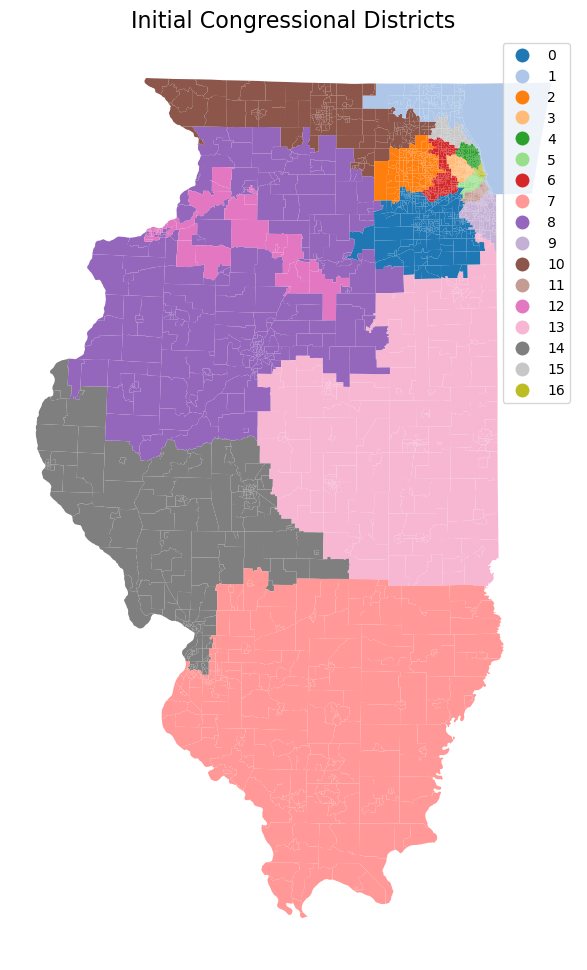

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(districtsinitial):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

cmap = mcolors.ListedColormap(plt.cm.tab20.colors[:17])

fig, ax = plt.subplots(figsize=(12, 12))
il_redistricting.data.plot(
    column='district', 
    cmap=cmap, 
    legend=True, 
    categorical=True, 
    ax=ax
)

ax.set_title("Initial Congressional Districts", fontsize=16)
ax.set_axis_off()

plt.show()


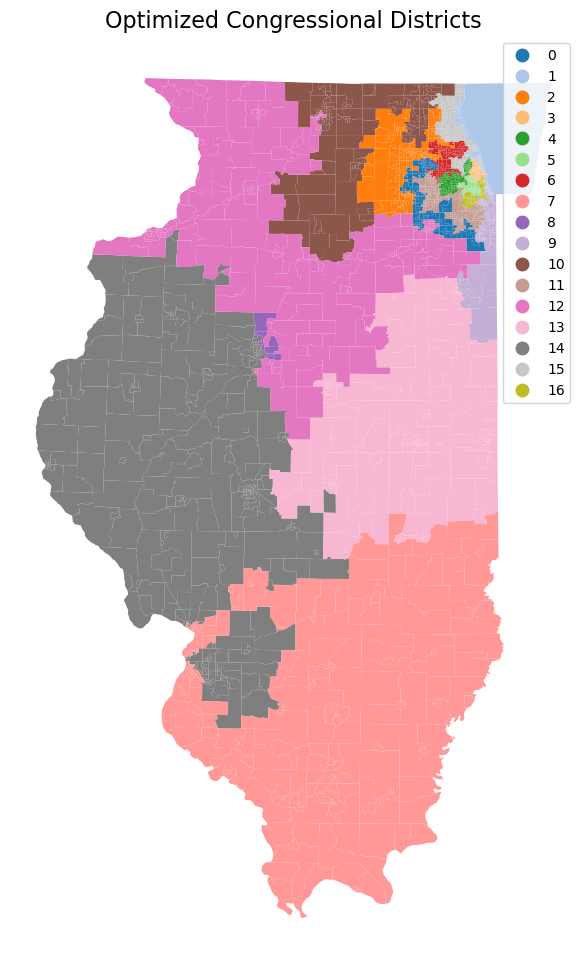

In [50]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(optimal_districts):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

cmap = mcolors.ListedColormap(plt.cm.tab20.colors[:17])

fig, ax = plt.subplots(figsize=(12, 12))
il_redistricting.data.plot(
    column='district', 
    cmap=cmap, 
    legend=True, 
    categorical=True, 
    ax=ax
)

ax.set_title("Optimized Congressional Districts", fontsize=16)
ax.set_axis_off()

plt.show()


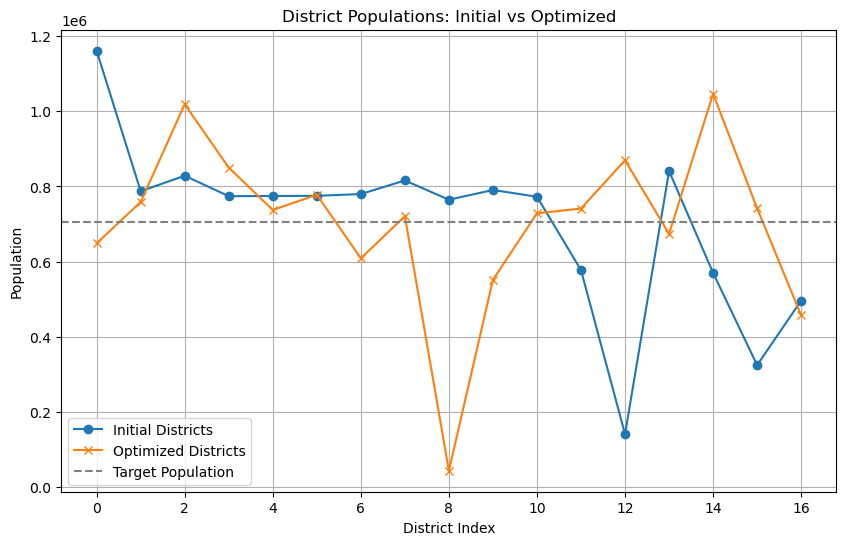

In [ ]:
import matplotlib.pyplot as plt

def calculate_district_populations(districts, data):
    return [
        sum(data[data['tract_code'].isin(district)]['population'])
        for district in districts
    ]

initial_populations = calculate_district_populations(districtsinitial, il_redistricting.data)
optimized_populations = calculate_district_populations(optimal_districts, il_redistricting.data)

plt.figure(figsize=(10, 6))
plt.plot(initial_populations, label="Initial Districts", marker='o')
plt.plot(optimized_populations, label="Optimized Districts", marker='x')
plt.axhline(
    il_redistricting.data['population'].sum() / il_redistricting.n_districts,
    color='gray', linestyle='--', label="Target Population"
)

plt.title("District Populations: Initial vs Optimized")
plt.xlabel("District Index")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.show()
